In [2]:
#pip install tensorflow scikit-learn matplotlib

In [1]:
#pip install tensorflow

https://www.kaggle.com/code/tahmidmir/skin-cancer-cnn-swin-t-restnet50-xgboost/input



Skin Cancer is a critical health concern, with early detection being vital for effective treatment. In this project, we aim to classify skin lesions using machine learning models, leveraging both Convolutional Neural Networks (CNNs) and state-of-the-art transfer learning techniques.

Baseline Model: CNN

We start by building a CNN as our baseline model. The CNN architecture, with its ability to automatically learn hierarchical features from images, serves as a solid foundation. The model is trained on the skin cancer dataset, where it learns to identify different types of skin lesions. While CNNs are powerful, they often require extensive data and may struggle with complex patterns, leading us to explore more advanced models.

Swin Transformer

Next, we implement the Swin Transformer, a novel architecture that has shown remarkable success in vision tasks. By leveraging the self-attention mechanism, the Swin Transformer captures long-range dependencies in images, making it well-suited for skin cancer classification. We fine-tune a pre-trained Swin Transformer model on our dataset, expecting it to outperform the baseline CNN due to its advanced feature extraction capabilities.

Transfer Learning with ResNet50

Finally, we use ResNet50, a widely recognized deep learning model known for its residual connections that help in training deep networks. By employing transfer learning, we fine-tune a pre-trained ResNet50 model on the skin cancer dataset. ResNet50's ability to preserve the integrity of the gradients during backpropagation makes it a strong candidate for improving classification accuracy.

Conclusion

This approach allows us to compare the performance of a traditional CNN with cutting-edge transfer learning models like Swin Transformer and ResNet50. The results from this study will help us understand the trade-offs between different architectures and identify the most effective model for skin cancer classification. By harnessing the power of advanced deep learning techniques, we aim to contribute to more accurate and early detection of skin cancer, ultimately improving patient outcomes. Source: (Internet).

In [3]:
pwd

'C:\\Users\\CAN\\Desktop\\ds_works'

About Dataset
¶
Skin Cancer: Malignant vs Benign

This dataset contains a balanced dataset of images of benign skin moles and malignant skin moles.

The data consists of two folders with each 1800 pictures (224x244) of the two types of moles.

Found 2638 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


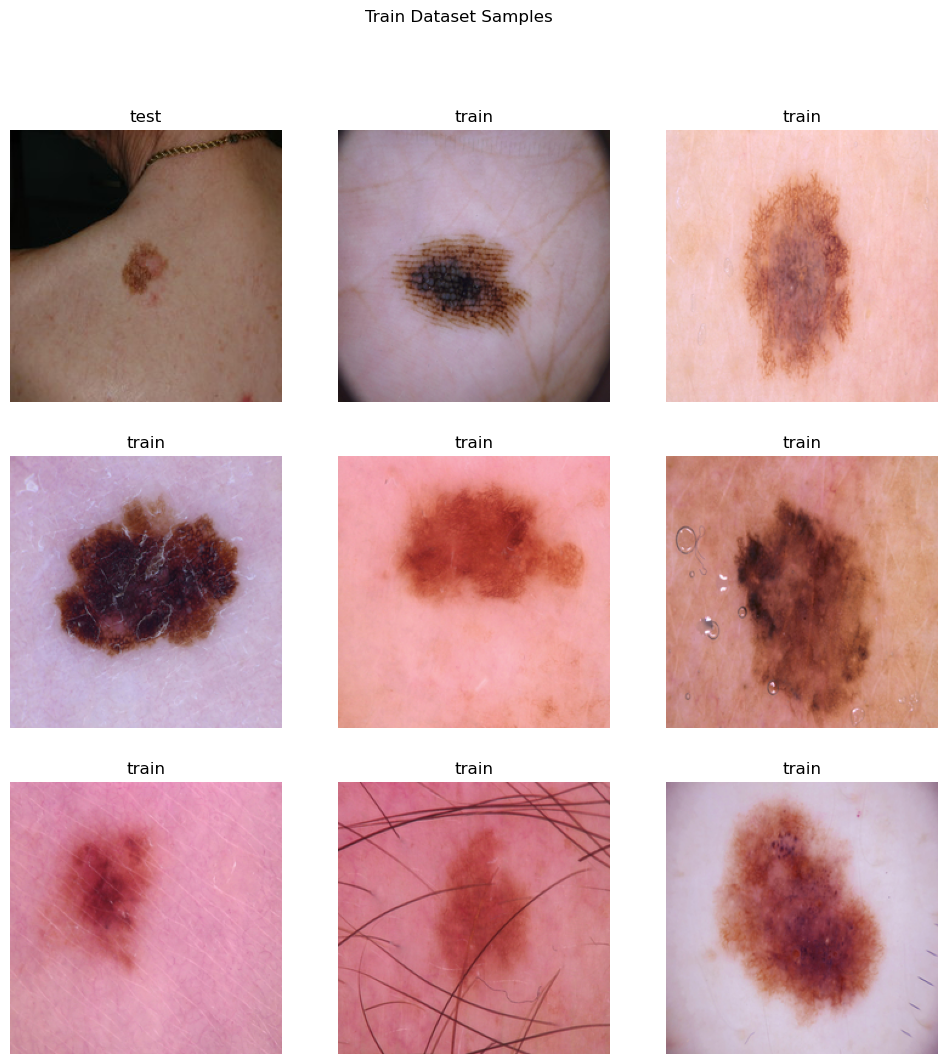

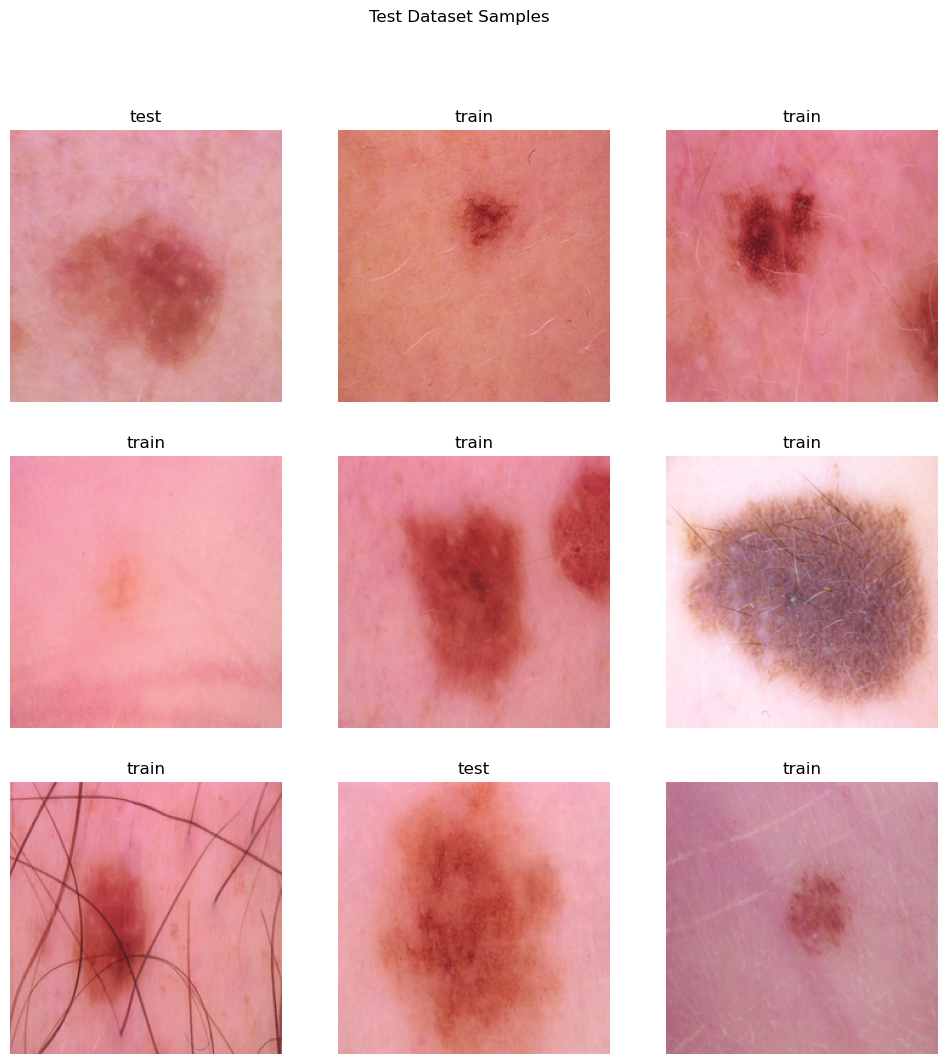

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
data_dir = 'data'

# Image Data Generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Visualize some images from the train and validation datasets
def plot_images(generator, title):
    class_names = {v: k for k, v in train_generator.class_indices.items()}
    plt.figure(figsize=(12, 12))
    for i in range(9):
        img, label = next(generator)
        plt.subplot(3, 3, i+1)
        plt.imshow(img[0])
        plt.title(class_names[int(label[0])])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(train_generator, 'Train Dataset Samples')
plot_images(validation_generator, 'Test Dataset Samples')

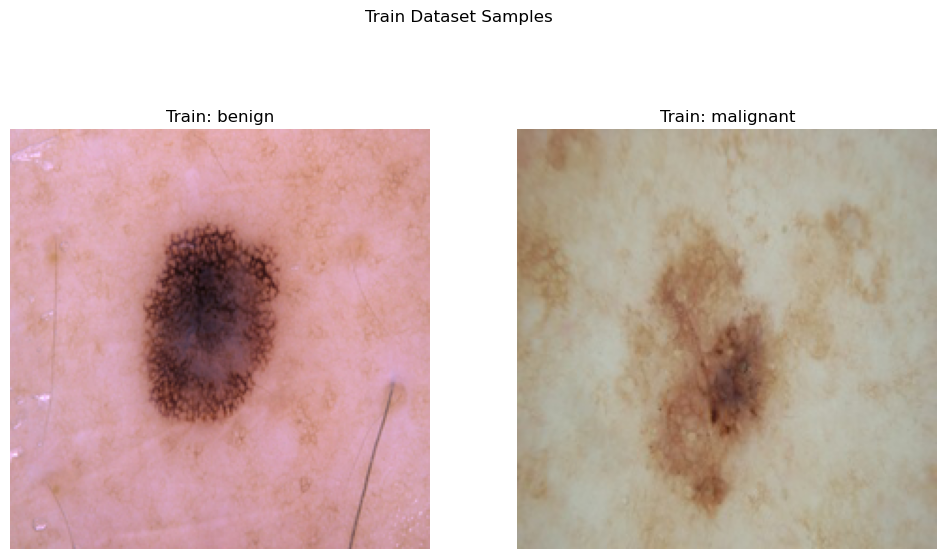

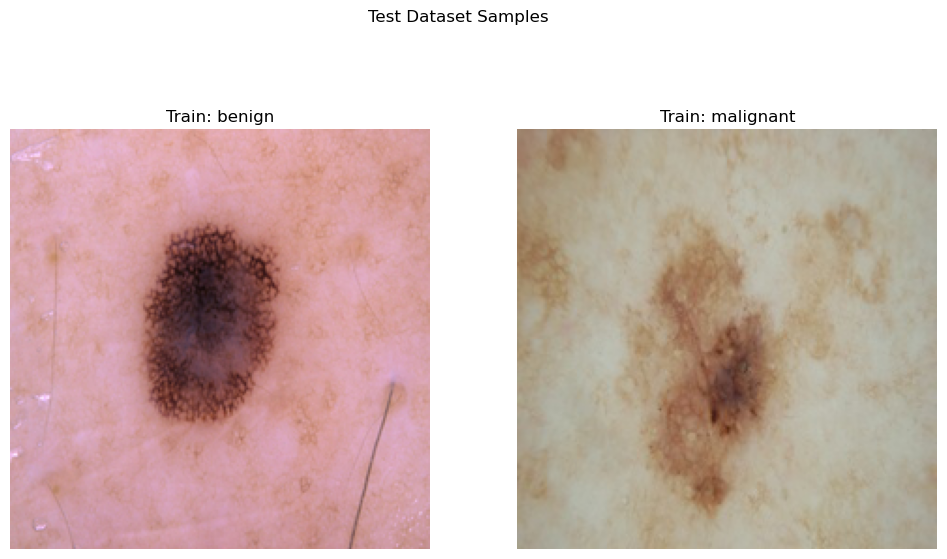

In [6]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths
train_dir = 'data/train'
test_dir = 'data/train'

# Function to plot images from a directory
def plot_images_from_directory(directory, title):
    class_names = os.listdir(directory)
    num_classes = len(class_names)

    plt.figure(figsize=(12, 12))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        image_path = os.path.join(class_dir, os.listdir(class_dir)[0])  # Take the first image from each class
        img = load_img(image_path, target_size=(224, 224))
        plt.subplot(2, num_classes, i + 1)
        plt.imshow(img)
        plt.title(f'Train: {class_name}')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Visualize train dataset
plot_images_from_directory(train_dir, 'Train Dataset Samples')

# Visualize test dataset
plot_images_from_directory(test_dir, 'Test Dataset Samples')

Convolutional Neural Networks (CNNs) are a type of deep learning model that are particularly well-suited for processing and analyzing spatial data, such as images and videos. CNNs are designed to automatically learn and extract useful features from the input data, making them highly effective for tasks like image classification, object detection, and image segmentation.

The key components of a CNN architecture are:

Convolutional Layers: These layers apply a set of learnable filters (or kernels) to the input data, extracting local features and patterns. The filters are learned during the training process.

Pooling Layers: These layers reduce the spatial size of the feature maps, making the representation more manageable and invariant to small translations in the input.

Fully Connected Layers: These layers connect all neurons from the previous layer to produce the final output, such as class probabilities in a classification task.

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [9]:
# Define paths
train_dir = 'data/train'
test_dir = 'data/test'

# Image Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Build and Train CNN Model

In [ ]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Build the model
model = build_cnn_model(input_shape=(224, 224, 3))
model.summary()

Compile the Model

In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

Train the Model with Early Stopping

In [ ]:
# Early stopping and model checkpoints
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_model_best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Evaluate the Model

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

In [ ]:
Visualize Training History

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Generate Confusion Matrix and Additional Metrics

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model(model, generator):
    # Predict probabilities for test set
    y_pred_prob = model.predict(generator)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)

    # Confusion Matrix
    cm = confusion_matrix(generator.classes, y_pred)
    class_names = list(generator.class_indices.keys())

    # Classification Report
    cr = classification_report(generator.classes, y_pred, target_names=class_names, output_dict=True)

    # ROC Curve
    fpr, tpr, _ = roc_curve(generator.classes, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot Confusion Matrix
    plot_confusion_matrix(cm, class_names)

    # Print Classification Report
    print('Classification Report:')
    for key, value in cr.items():
        if isinstance(value, dict):
            print(f'\nClass: {key}')
            for k, v in value.items():
                print(f'{k}: {v}')

# Evaluate the model
evaluate_model(model, validation_generator)

In [ ]:
Plot ROC Curve and Calculate AUC

In [ ]:
def plot_roc_curve(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(model, validation_generator)

XGBoost

In [11]:
pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 393.8 kB/s eta 0:05:18
   ---------------------------------------- 0.1/124.9 MB 655.4 kB/s eta 0:03:11
   ---------------------------------------- 0.2/124.9 MB 984.6 kB/s eta 0:02:07
   ---------------------------------------- 0.2/124.9 MB 1.2 MB/s eta 0:01:48
   ---------------------------------------- 0.3/124.9 MB 1.4 MB/s eta 0:01:32
   ---------------------------------------- 0.4/124.9 MB 1.4 MB/s eta 0:01:27
   ---------------------------------------- 0.4/124.9 MB 1.4 MB/s eta 0:01:27
   ---------------------------------------- 0.4/124.9 MB 1.1 MB/s eta 0:01:55
   ---------------------------------------- 0.4/124.9 MB 1.1 MB/s eta 0:01:57
   ---------------------------------------- 0.4/124.9 MB 1.1 MB/s eta 0:01:57


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 95s 1us/step
Found 2637 images belonging to 2 classes.


C:\Users\CAN\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step
Accuracy: 0.8826
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       283
           1       0.86      0.90      0.88       245

    accuracy                           0.88       528
   macro avg       0.88      0.88      0.88       528
weighted avg       0.88      0.88      0.88       528



<Figure size 1000x800 with 0 Axes>

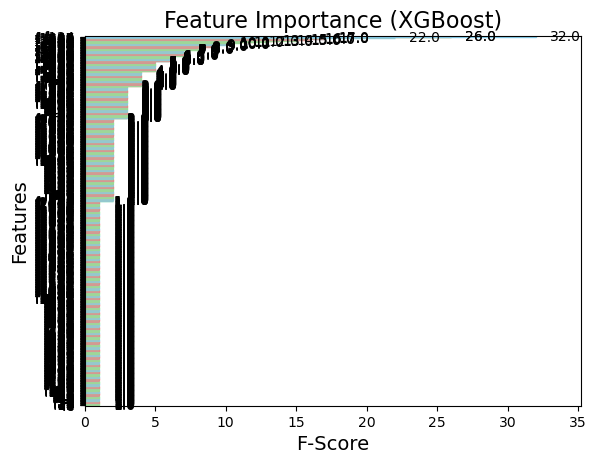

In [12]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Define paths
train_dir = 'data/train'
test_dir = 'data/test'

# Load ResNet50 model pre-trained on ImageNet, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Set up image data generator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create a generator for the training data
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Extract features using ResNet50
features = base_model.predict(train_generator)
labels = train_generator.classes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# If you'd like to plot feature importance
import matplotlib.pyplot as plt

# Plot feature importance with customization
plt.figure(figsize=(10, 8))
ax = xgb.plot_importance(xgb_model, importance_type='weight', color='skyblue', height=0.8)

# Customize the plot to make it colorful
ax.set_title('Feature Importance (XGBoost)', fontsize=16)
ax.set_xlabel('F-Score', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.grid(False)

# Set different colors for bars
for i, bar in enumerate(ax.patches):
    if i % 3 == 0:
        bar.set_color('skyblue')
    elif i % 3 == 1:
        bar.set_color('lightcoral')
    else:
        bar.set_color('lightgreen')

plt.show()